## Finding most significant DHS scale for an ROI: Idea is to find the mid-point of ROI and expand around it for a fixed no. of iterations

In [1]:
import sys
import os
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import rankdata

In [2]:
#Metric to use for ranking
metric=pd.read_csv('../../ranking_metrics/results/coranked_metrics3',sep='\t')
#Vocabulary with DHS indices
vocab = pd.read_csv('../../dhs_data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt',sep='\t')

/tmp/ipykernel_124277/3492429547.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vocab = pd.read_csv('../../dhs_data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt',sep='\t')


In [3]:
metric

,means-cos_snr,max_metric
0,2403534.5,mean_cosine_similarity
1,1670757.0,snr
2,378904.5,snr
3,1386832.0,snr
4,1950693.5,snr
...,...,...
3591893,3122645.5,snr
3591894,1912274.0,snr
3591895,998487.0,snr
3591896,2735793.5,snr


In [4]:
vocab

,seqname,start,end,identifier,mean_signal,numsamples,summit,core_start,core_end,component
0,chr1,16140,16200,1.10011,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1,chr1,51868,52040,1.10021,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
2,chr1,57280,57354,1.10025,0.273251,4,57350,57350.0,57350.0,Neural
3,chr1,66370,66482,1.10027,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
4,chr1,79100,79231,1.1003,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...,...
3591893,chrY,56882540,56882719,Y.994281,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
3591894,chrY,56882864,56882980,Y.994286,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
3591895,chrY,56883733,56883960,Y.994292,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast
3591896,chrY,56884440,56884580,Y.994297,0.053759,1,56884510,56884510.0,56884510.0,Lymphoid


In [5]:
def find_scale_of_significance(ch,win_start,win_stop):
    #Parameters: ROI: chromosome, start and end positions
    
    #Data frame and index to use to write information about expanding region in it
    test_roi_scale=pd.DataFrame()
    index_to_use=0
    
    #Mean and Standard Deviation of the metric used to rank a regions (Co-ranking of SNR and MCS)
    population_mean = np.mean(metric.iloc[:,0])
    population_std_dev = np.std(metric.iloc[:,0])
    
    #Length of query region
    win_length=win_stop-win_start+1
    
    #Base pair to expand around
    base_pair_roi = win_start+int((win_length/2))
    
    #Beginning with a 100 bp window in the middle of ROI
    new_win_start=base_pair_roi-50
    new_win_stop=base_pair_roi+50
    
    #Starting with 100,000 iterations around the middle of ROI
    range_start=0
    range_stop=100000
    #step is the no. of bp to expand around middle of ROI
    step=10
    
    #Variable to keep track of whether p-value becomes zero
    zero_pval = False
    
    for i in range(range_start,range_stop,step):
        new_win_start = new_win_start-step
        new_win_stop = new_win_stop+step
        new_length = new_win_stop - new_win_start + 1
        
        #Indices of no. of DHSs in a region 
        x = np.where((vocab.seqname==ch) & (vocab.start >= new_win_start) & (vocab.start <= new_win_stop) )[0]
        no_of_dhs_in_region=len(x)
        if no_of_dhs_in_region==0:
            continue
            
        #Sample mean for CLT
        mean_metric = np.nanmean(metric.iloc[x,0])
        
        #z-score for the mean ranking metric in a window
        z = (mean_metric-population_mean)/(population_std_dev/np.sqrt(no_of_dhs_in_region))
        
        #p-value computation
        if z>0:
            pval = 1-norm.cdf(z)
        else:
            pval = norm.cdf(z)
        
        if ((pval == 0) & (zero_pval==False)):
            zero_pval = True    
        
        test_roi_scale.loc[index_to_use,'seqname']=ch
        test_roi_scale.loc[index_to_use,'start'] = int(new_win_start)
        test_roi_scale.loc[index_to_use,'end'] = int(new_win_stop)
        test_roi_scale.loc[index_to_use,'length'] = new_win_stop-new_win_start
        test_roi_scale.loc[index_to_use,'no_of_dhs'] = no_of_dhs_in_region
        test_roi_scale.loc[index_to_use,'mean_coranking_metric'] = mean_metric
        test_roi_scale.loc[index_to_use,'pvalue'] = pval
        index_to_use+=1
    
    #making p-values of zero to be half of non-zero minimum
    if zero_pval:
        test_roi_scale = make_pval_non_zero(test_roi_scale)
    return test_roi_scale

In [6]:
#Function to make p-values non-zero
def make_pval_non_zero(scale_roi):
    
    #Obtain ranks of all p-values
    ranks_pval = rankdata(scale_roi.pvalue,method='dense')
    
    #Find indices where p-values are zero
    zero_indices = np.where(scale_roi.pvalue==0)[0]
    
    #Value with which to replace zeros: half of non-zero minimum
    value_to_replace = (scale_roi.pvalue[np.where(ranks_pval==2)[0][0]])/2
    
    scale_roi.pvalue[zero_indices] = value_to_replace
    return scale_roi

In [7]:
#Using the beta globin region as example ROI
test_roi_scale=find_scale_of_significance(ch='chr11',win_start=5270000,win_stop=5305000)

In [8]:
test_roi_scale

,seqname,start,end,length,no_of_dhs,mean_coranking_metric,pvalue
0,chr11,5287440.0,5287560.0,120.0,1.0,1.439678e+06,3.178130e-01
1,chr11,5287430.0,5287570.0,140.0,1.0,1.439678e+06,3.178130e-01
2,chr11,5287420.0,5287580.0,160.0,1.0,1.439678e+06,3.178130e-01
3,chr11,5287410.0,5287590.0,180.0,1.0,1.439678e+06,3.178130e-01
4,chr11,5287400.0,5287600.0,200.0,1.0,1.439678e+06,3.178130e-01
...,...,...,...,...,...,...,...
9995,chr11,5187490.0,5387510.0,200020.0,254.0,1.206846e+06,4.416644e-36
9996,chr11,5187480.0,5387520.0,200040.0,254.0,1.206846e+06,4.416644e-36
9997,chr11,5187470.0,5387530.0,200060.0,254.0,1.206846e+06,4.416644e-36
9998,chr11,5187460.0,5387540.0,200080.0,254.0,1.206846e+06,4.416644e-36


Text(0, 0.5, 'Log transformed p-value')

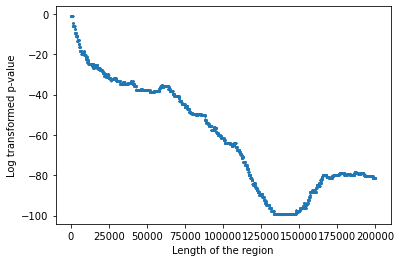

In [9]:
plt.scatter(test_roi_scale.length,np.log(test_roi_scale.pvalue),s=1)
plt.xlabel('Length of the region')
plt.ylabel('Log transformed p-value')

In [10]:
#Another ROI, from ranking of 25kb regions
test_roi_scale=find_scale_of_significance(ch='chr4',win_start=173514800,win_stop=173539800)

/tmp/ipykernel_115375/3234077140.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale_roi.pvalue[zero_indices] = value_to_replace


Text(0, 0.5, 'Log transformed p-value')

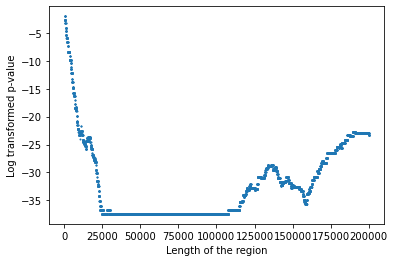

In [11]:
plt.scatter(test_roi_scale.length,np.log(test_roi_scale.pvalue),s=1)
plt.xlabel('Length of the region')
plt.ylabel('Log transformed p-value')

In [12]:
test_roi_scale

,seqname,start,end,length,no_of_dhs,mean_coranking_metric,pvalue
0,chr4,173527200.0,173527400.0,200.0,1.0,2.630488e+06,1.335221e-01
1,chr4,173527190.0,173527410.0,220.0,1.0,2.630488e+06,1.335221e-01
2,chr4,173527180.0,173527420.0,240.0,1.0,2.630488e+06,1.335221e-01
3,chr4,173527170.0,173527430.0,260.0,1.0,2.630488e+06,1.335221e-01
4,chr4,173527160.0,173527440.0,280.0,1.0,2.630488e+06,1.335221e-01
...,...,...,...,...,...,...,...
9991,chr4,173427290.0,173627310.0,200020.0,353.0,2.052248e+06,7.554346e-11
9992,chr4,173427280.0,173627320.0,200040.0,353.0,2.052248e+06,7.554346e-11
9993,chr4,173427270.0,173627330.0,200060.0,353.0,2.052248e+06,7.554346e-11
9994,chr4,173427260.0,173627340.0,200080.0,353.0,2.052248e+06,7.554346e-11
